# Tully-Fisher Relation of galaxies

For all galaxies in fuji which have valid rotational velocities at $0.33R_{26}$, plot their TFR.  Also include the best-fit TFR (as calibrated using `joint-Coma-0pt_Fuji-TFR_KAD_varyV0-perpdwarf_AnthonyUpdates_weightsVmax-1.ipynb`).

In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy import cosmology
from astropy.cosmology import Planck18, LambdaCDM
import astropy.units as u
import astropy.constants as const

import numpy as np

from scipy.stats import binned_statistic

from tqdm import tqdm

import pickle

#import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
h = 1
H0 = 100*h

# c = 3e5
c = const.c.to('km/s')

q0 = 0.2

# V0 was set as the median value of all the data used in the final calibration

# Data

In [3]:
#tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- cori
# tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot_photsys.fits')
SGA_TF['V_0p33R26_err'].name = 'V_0p33R26_ERR'
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_ERR,TARGETID,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,int64,bytes1
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291883,0.0051505533,0.005328927,0.005367155,0.005074676,0.005267603,0.0053163357,16.432898,0.27237165,3.4572394,5.399334,1.6520585,15.889806,0.2892297,2.7702796,4.85128,0.7334321,15.531683,0.31152296,2.403034,4.429238,0.75814104,0,0.0224279674032048,2.44404472261522e-05,65.28941302448953,11.22724382461

# Convert redshift to CMB frame

In [4]:
SGA_TF['Z_DESI_CMB'] = convert_z_frame(SGA_TF['Z_DESI'], SGA_TF['RA'], SGA_TF['DEC'])

# Photometric corrections

### Survey offsets

In [5]:
SGA_sys_corr, SGA_sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])

### Dust corrections

In [6]:
# Import E(B-V) map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [7]:
SGA_dust_corr, SGA_dust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [8]:
# Flip NaN values to 0
SGA_dust_corr_err[np.isnan(SGA_dust_corr_err)] = 0

### $K$-corrections

In [9]:
SGA_kcorr = k_corr(SGA_TF['Z_DESI'], 
                   [SGA_TF['G_MAG_SB26'], SGA_TF['R_MAG_SB26'], SGA_TF['Z_MAG_SB26']], 
                   [SGA_TF['G_MAG_SB26_ERR'], SGA_TF['R_MAG_SB26_ERR'], SGA_TF['Z_MAG_SB26_ERR']])

### Internal dust extinction correction

This is based off a linear fit to $(m_r, b/a)$, removing any correlation between $b/a$ and $m_r$.

In [10]:
temp_infile = open('fuji_internalDust_mcmc-20250205.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [11]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [12]:
internalDust_corr, internalDust_corr_err = internal_dust(SGA_TF['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [13]:
SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - SGA_dust_corr[1] + SGA_sys_corr + SGA_kcorr[:,1] - internalDust_corr
SGA_TF['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + SGA_dust_corr_err[1]**2 + SGA_sys_corr_err**2 + internalDust_corr_err**2)

# TFR

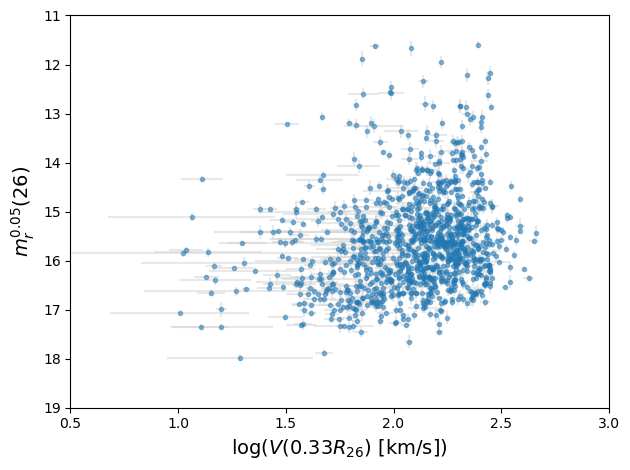

In [14]:
plt.figure(tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             ecolor='lightgray',
             alpha=0.5)

plt.xlim([0.5, 3])
plt.ylim([19, 11])

plt.xlabel('log($V(0.33R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$m_r^{0.05} (26)$', fontsize=14);

# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box');

## Compute the absolute magnitudes based on the redshift

In [15]:
def cosmo_mu(H0, Om0, z):
    '''
    Calculate the distance modulus for a given H0 and Omega_M0.  Assumes a flat 
    Lambda CDM cosmology.
    
    PARAMETERS
    ==========
    H0 : ndarray of shape (1,)
        Hubble constant.  Must be in units of km/s/Mpc.
    Om0 : float
        Omega_M0.  Must have a value between 0 and 1.
    z : float or ndarray of shape (n,)
        redshift at which to calculate distance modulus.
    
    RETURNS
    =======
    mu : float or ndarray of shape (n,)
        Distance modulus for the given H0 and Omega_M0.
    '''
    cosmo = cosmology.FlatLambdaCDM(H0=H0*u.km/(u.s*u.Mpc), Om0=Om0)
    mu = cosmo.distmod(z)
    return mu.value

In [16]:
SGA_TF['MU_zCMB'] = cosmo_mu(H0, 0.3151, SGA_TF['Z_DESI_CMB'])

In [17]:
mu_err = np.zeros(len(SGA_TF['MU_zCMB']))

rng = np.random.default_rng()

for i in tqdm(range(len(mu_err))):

    z_random = rng.normal(SGA_TF['Z_DESI_CMB'][i], SGA_TF['ZERR_DESI'][i], size=10000)

    mu_random = cosmo_mu(H0, 0.3151, z_random)

    mu_err[i] = np.nanstd(mu_random)

SGA_TF['MU_zCMB_ERR'] = mu_err

100%|██████████| 1164/1164 [00:08<00:00, 133.99it/s]


In [18]:
SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26'] - SGA_TF['MU_zCMB']
SGA_TF['R_ABSMAG_SB26_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + SGA_TF['MU_zCMB_ERR']**2)

SGA_TF['R_ABSMAG_SB26_CORR'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['MU_zCMB']
SGA_TF['R_ABSMAG_SB26_CORR_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['MU_zCMB_ERR']**2)

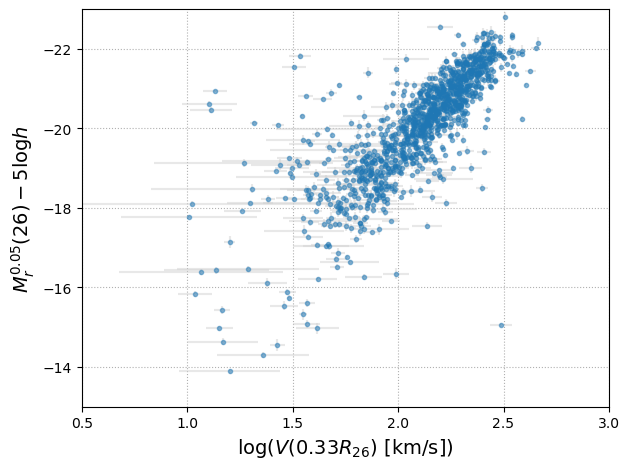

In [19]:
# plt.figure(figsize=(5,7), tight_layout=True)
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_ABSMAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_ABSMAG_SB26_CORR_ERR'], 
             fmt='.', 
             alpha=0.5, 
             ecolor='lightgray')

plt.xlim([0.5, 3])
plt.ylim([-13, -23])

plt.xlabel('log($V(0.33R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.05} (26) - 5$log$h$', fontsize=14);

# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box');

## Plotted with our TFR

In [20]:
logv = np.linspace(-1, 3, 100)

### Calibration without dwarfs

Here, $V_0$, the slope, and the y-intercept are from `joint-Coma-0pt-Fuji-TFR_KAD_varyV0-perpdwarfs_AnthonyUpdates_weightsVmax-1.ipynb`:

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

In [21]:
temp_infile = open('cov_ab_fuji_joint_TFR_varyV0-perpdwarfs0_AnthonyUpdates_weightsVmax-1_KAD.pickle', 'rb')
bright_cov_ab, tfr_samples_bright, V0 = pickle.load(temp_infile)
temp_infile.close()

In [22]:
bright_slope = np.median(tfr_samples_bright[0])
bright_slope_err = np.sqrt(bright_cov_ab[0,0])

bright_ZP = np.median(tfr_samples_bright[2])
bright_ZP_err = np.sqrt(bright_cov_ab[2,2])

bright_sig = np.median(tfr_samples_bright[-1])
bright_sig_err = np.sqrt(bright_cov_ab[-1,-1])

bright_absmag = bright_slope*(logv - V0) + bright_ZP

In [23]:
# Calculate the uncertainties in the calibrated TFR
bright_slopes = tfr_samples_bright[0]
bright_ZPs = tfr_samples_bright[2]

N_samples = len(bright_slopes)

bright_lines = []

for i in range(N_samples):
    bright_lines.append(bright_slopes[i]*(logv - V0) + bright_ZPs[i])
    
bright_lines_array = np.asarray(bright_lines)
bright_line_err = np.nanpercentile(bright_lines_array, [16 ,84], axis=0)

In [24]:
logV_n17_bright = (-17 - bright_ZP)/bright_slope + V0
b_perp_bright = -17 + (1/bright_slope)*(logV_n17_bright - V0)

dwarf_boolean = (SGA_TF['R_ABSMAG_SB26_CORR'] - SGA_TF['R_ABSMAG_SB26_CORR_ERR']) > (-(np.log10(SGA_TF['V_0p33R26']) - V0)/bright_slope + b_perp_bright)

print(10**(logV_n17_bright), 'km/s')

49.18383939670343 km/s


In [25]:
print(sum(dwarf_boolean), 'dwarfs')
print(len(SGA_TF) - sum(dwarf_boolean), 'non-dwarfs')

27 dwarfs
1137 non-dwarfs


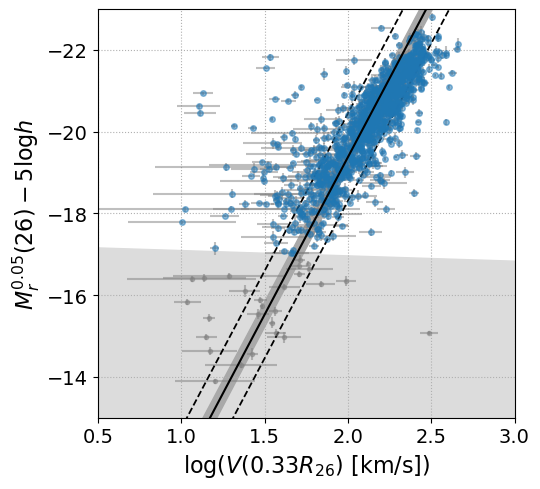

In [27]:
yvals_perp_bright = -(logv - V0)/bright_slope + b_perp_bright

# plt.figure(figsize=(4,8), tight_layout=True)
plt.figure(figsize=(5.5,5), tight_layout=True)

plt.grid(ls=':')

# plt.plot(logv, yvals_perp_bright, 'r:')
plt.fill_between(logv, yvals_perp_bright, -12, color='gainsboro')

plt.fill_between(logv, bright_line_err[0], bright_line_err[1], color='darkgray')

plt.errorbar(np.log10(SGA_TF['V_0p33R26'][~dwarf_boolean]), 
             SGA_TF['R_ABSMAG_SB26_CORR'][~dwarf_boolean], 
             xerr=0.434*SGA_TF['V_0p33R26_ERR'][~dwarf_boolean]/SGA_TF['V_0p33R26'][~dwarf_boolean],
             yerr=SGA_TF['R_ABSMAG_SB26_CORR_ERR'][~dwarf_boolean], 
             fmt='o', 
             markersize=4, 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(np.log10(SGA_TF['V_0p33R26'][dwarf_boolean]), 
             SGA_TF['R_ABSMAG_SB26_CORR'][dwarf_boolean], 
             xerr=0.434*SGA_TF['V_0p33R26_ERR'][dwarf_boolean]/SGA_TF['V_0p33R26'][dwarf_boolean],
             yerr=SGA_TF['R_ABSMAG_SB26_CORR_ERR'][dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

plt.plot(logv, bright_absmag, 'k', zorder=3)
plt.plot(logv, bright_absmag - bright_sig, c="k", marker="None", ls="--", lw=1.3)
plt.plot(logv, bright_absmag + bright_sig, c="k", marker="None", ls="--", lw=1.3)

plt.xlim([0.5, 3])
plt.ylim([-13, -23])

plt.xlabel('log($V(0.33R_{26})$ [km/s])', fontsize=16)
plt.ylabel('$M_r^{0.05} (26) - 5$log$h$', fontsize=16);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_aspect('equal', adjustable='box');

plt.savefig('../../Figures/SV/fuji_jointTFR_varyV0-perpdwarf_zCMB_AnthonyUpdates_weightsVmax-1_20250522.png', 
            dpi=150, 
            facecolor='none');

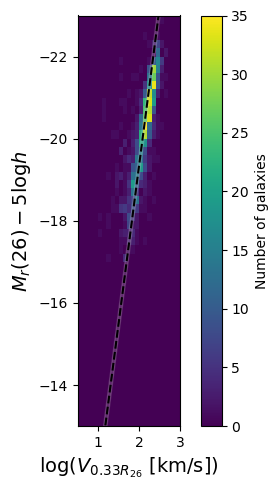

In [49]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hist2d(np.log10(SGA_TF['V_0p33R26'][~dwarf_boolean]), 
           SGA_TF['R_ABSMAG_SB26_CORR'][~dwarf_boolean], 
           bins=[np.arange(0.5,3.1,0.1), np.arange(-23, -11.9, 0.2)])
plt.colorbar(label='Number of galaxies')

plt.fill_between(logv, bright_line_err[0], bright_line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, bright_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3])
plt.ylim([-13, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14);

ax = plt.gca()
ax.set_aspect('equal', adjustable='box');

#### Redshift distribution

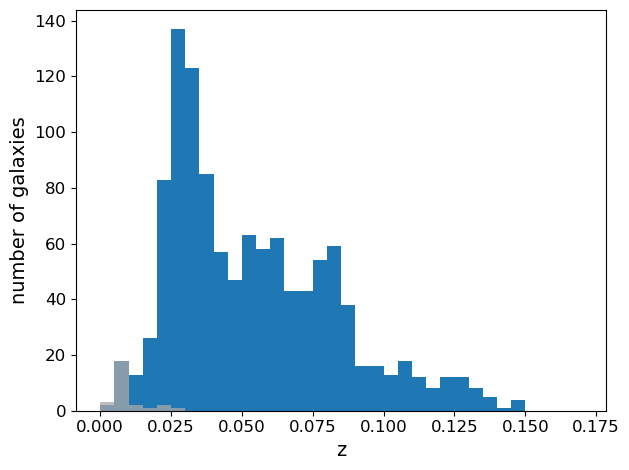

In [50]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
plt.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray', alpha=0.75)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('z', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_z_hist_20240521.png', dpi=150, facecolor='none');

# Compute distance modulus from TFR

In [29]:
SGA_TF['R_ABSMAG_SB26_TFbright'] = bright_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + bright_ZP

In [30]:
SGA_TF['R_ABSMAG_SB26_TFbright_err'] = np.nan

rng = np.random.default_rng()

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_ERR'][i], size=len(bright_slopes))
    
    Ms = bright_slopes*(np.log10(v_random) - V0) + bright_ZPs
    
    SGA_TF['R_ABSMAG_SB26_TFbright_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_1356671/666886111.py:9: RuntimeWarning: invalid value encountered in log10
  Ms = bright_slopes*(np.log10(v_random) - V0) + bright_ZPs


In [31]:
SGA_TF['MU_TFbright'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['R_ABSMAG_SB26_TFbright']

SGA_TF['MU_TFbright_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['R_ABSMAG_SB26_TFbright_err']**2)

### $\Delta M_r$ v. redshift

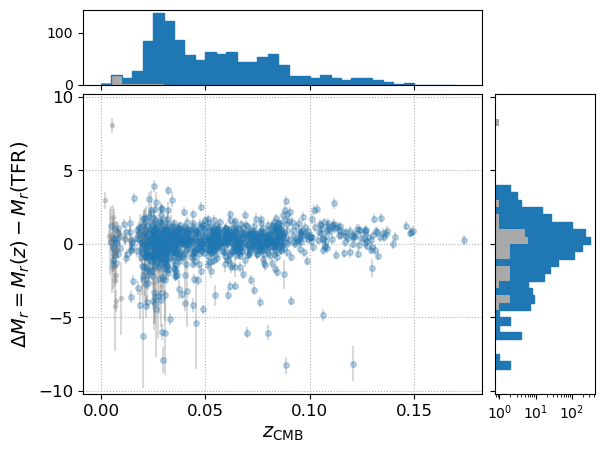

In [32]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
             SGA_TF['R_ABSMAG_SB26_CORR'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][~dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
             yerr=SGA_TF['MU_TFbright_ERR'][~dwarf_boolean],
             fmt='o', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
             SGA_TF['R_ABSMAG_SB26_CORR'][dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
             yerr=SGA_TF['MU_TFbright_ERR'][dwarf_boolean],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\Delta M_r = M_r(z) - M_r(\text{TFR})$', fontsize=14)

ax.set_ylim((-10.2, 10.2))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['R_ABSMAG_SB26_CORR'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][~dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26_CORR'][dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26_CORR'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][~dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False);

# plt.savefig('../../Figures/SV/fuji_deltaM-v-z_jointTFR-varyV0-perpdwarfs_zCMB_20250205.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

## $\eta$ v. redshift

In [33]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

In [34]:
SGA_TF['LOGDIST'] = 0.2*(SGA_TF['MU_zCMB'] - SGA_TF['MU_TFbright'])
SGA_TF['LOGDIST_ERR'] = 0.2*np.sqrt(SGA_TF['MU_zCMB_ERR']**2 + SGA_TF['MU_TFbright_ERR']**2)

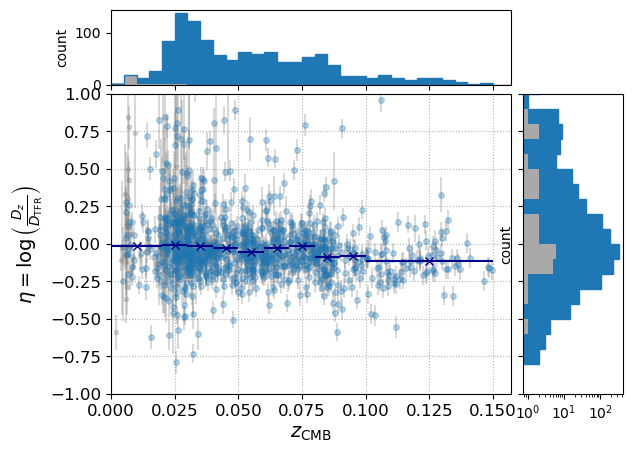

In [47]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['LOGDIST'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean],
            fmt='o', 
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['LOGDIST'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')

# Plot the mean, weighted by Vmax
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean],
                                    # median=True
                                    weighted=True
                                   )
ax.errorbar(zc[:-1], y_avg[:-1], xerr=dz[:-1], yerr=y_std[:-1], fmt='x', color='darkblue', zorder=3)

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_ylim((-1, 1))

ax.set_xlim((0, 0.157))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)

ax_histx.set_ylabel('count', fontsize=10)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)

ax_histy.set_ylabel('count', fontsize=10);

plt.savefig('../../Figures/SV/fuji_logdist-v-zCMB_jointTFR-varyV0-perpdwarfs_AnthonyUpdates_weightsVmax-1_20250404.png', 
            dpi=150, 
            facecolor='none', 
            bbox_inches='tight');

### Distance modulus v. redshift

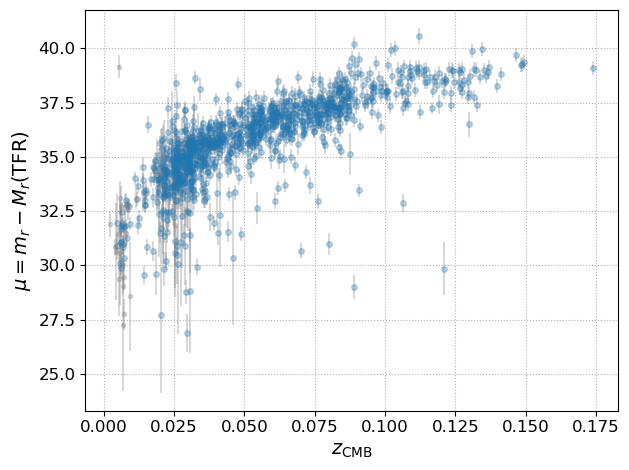

In [53]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
             SGA_TF['MU_TFbright'][~dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
             yerr=SGA_TF['MU_TFbright_ERR'][~dwarf_boolean],
             fmt='o', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')
plt.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
             SGA_TF['MU_TFbright'][dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
             yerr=SGA_TF['MU_TFbright_ERR'][dwarf_boolean],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

plt.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\mu = m_r - M_r(\text{TFR})$', fontsize=14);

### Save distance moduli to a fits file

In [56]:
hdr = fits.Header()

hdr['DESI_DR'] = 'EDR'
hdr['V_RADIUS'] = '0.33 R26'
hdr['M'] = bright_slope
hdr['M_ERR'] = bright_slope_err
hdr['0PT'] = bright_ZP
hdr['0PT_ERR'] = bright_ZP_err
hdr['V0'] = V0
hdr['SIG'] = np.median(tfr_samples_bright[-1])
hdr['SIG_ERR'] = np.sqrt(bright_cov_ab[-1,-1])
hdr['H0'] = H0

empty_primary = fits.PrimaryHDU(header=hdr)

In [57]:
table_hdu = fits.BinTableHDU(data=SGA_TF)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
hdul.writeto('SGA_fuji_jointTFR-varyV0-perpdwarf-zCMB_moduli.fits', overwrite=True)